# Libraries

In [1]:
import os
from pathlib import Path
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import pandas as pd

from metadata import ImageDataset, patient
import utils

In [2]:
notebooks_path = Path.cwd()
repo_path = notebooks_path.parent
print(f'The current directory is: {notebooks_path}')

The current directory is: /home/ricardino/Documents/MAIA/tercer_semestre/MISA/final_project/MISA_FINAL_PROJECT/notebooks


# Functions

In [3]:
def scale_to_bin_ratio(normalized_array, bin_ratio):
    """scales images using the bin_ratio so the output array has ine integer intensity values

    Args:
        normalized_array (array): image array normalised between 0 and 1
        bin_ratio (float): ration ebtween the maximum intensity of the original image and the maximum intensity of the preprocessed image

    Returns:
        _type_: _description_
    """
    return np.rint(normalized_array/bin_ratio).astype(np.uint16)

def get_maxmin_intensity(im_data, preprocess=False, rescaled=False, bin_ratio:float=0):
    
    max_int = 0 #initialize max intensity
    min_int = 0 #initialize min intensity

    for id in im_data.IDs:
        pat = patient(id, im_data)
        im = pat.im(format='np', preprocess=preprocess)
        im = scale_to_bin_ratio(im, bin_ratio=bin_ratio) if rescaled else im
        im_max = np.max(im)
        im_min = np.min(im)
        if im_max > max_int: #Substitute global maximum if necessary
            max_int = im_max
        if im_min < min_int:
            min_int = im_min

    print(f'The maximum intensity is {max_int}')
    print(f'The minimum intensity is {min_int}')
    return max_int, min_int

In [4]:
def normalize_histogram(tot_csf, tot_gm, tot_wm):
    tot_csf = tot_csf/np.sum(tot_csf)
    tot_wm = tot_wm/np.sum(tot_wm)
    tot_gm = tot_gm/np.sum(tot_gm)
    
    return tot_csf, tot_gm, tot_wm

# Section 0: Check ground truth

We check that the ground truth has the order we expect: CSF (1), GM (2) and WM (3).

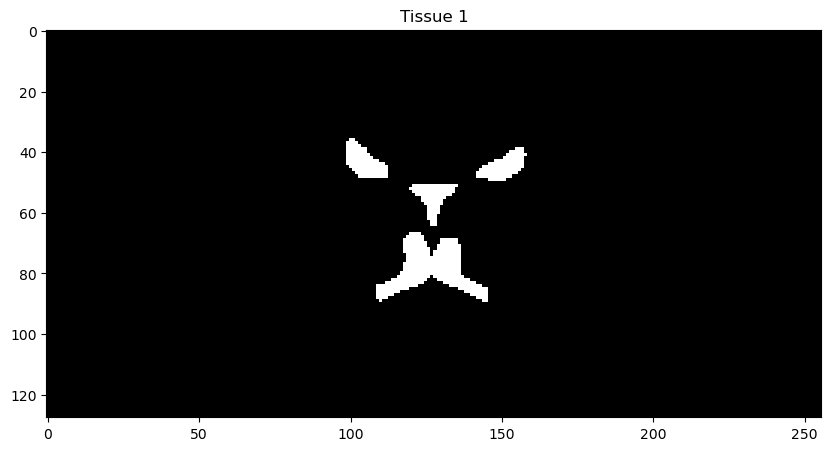

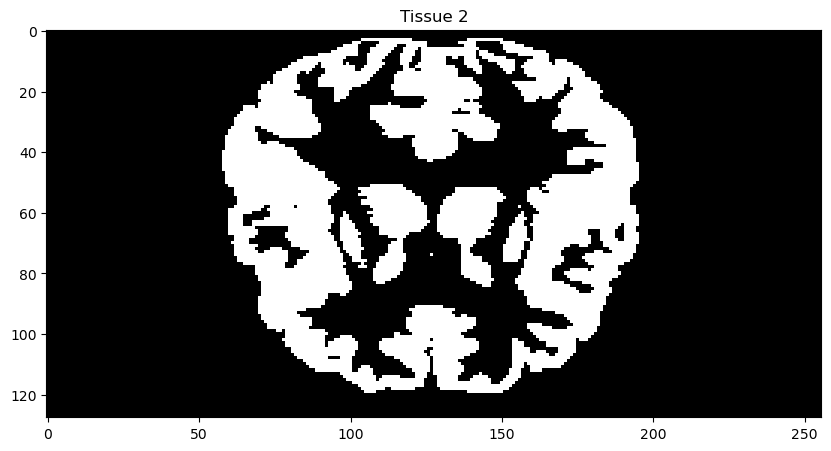

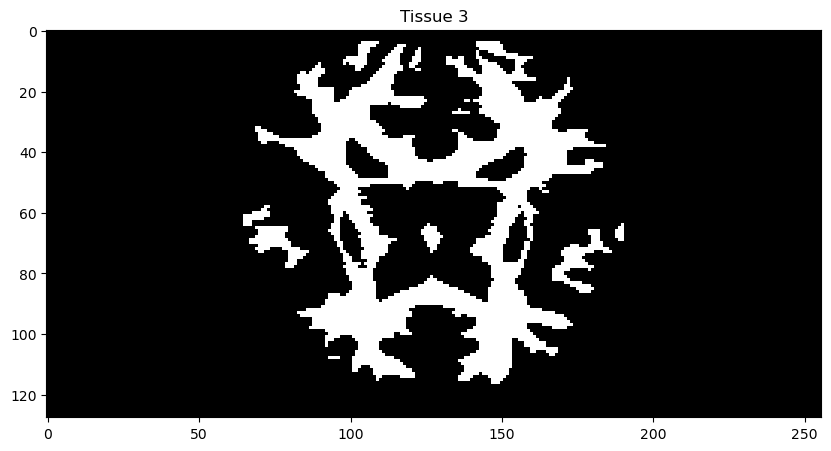

In [13]:
im_data = ImageDataset(set_name='Training')
id = im_data.IDs[0]
pat = patient(id, im_data)

im_array = pat.labels(format='np')
for tissue in range(1,4):    
    plt.figure(figsize=(10,10))
    plt.title(f'Tissue {tissue}')
    plt.imshow(im_array[140,:,:]==tissue, cmap='gray')

# Section 1: Get the minimum and maximum intensity

We get the minimum and maximum intensity for all images before and after preprocessing.

In [14]:
im_data = ImageDataset(set_name='Training')

original_max, _ = get_maxmin_intensity(im_data, preprocess=False)
prepross_max,_ = get_maxmin_intensity(im_data, preprocess=True)
bin_ratio = prepross_max/original_max
print(f'The bin ratio is {bin_ratio}')

The maximum intensity is 215
The minimum intensity is 0
The maximum intensity is 2.282848794416359
The minimum intensity is 0
The bin ratio is 0.010617901369378414


The `bin_ratio` help us know how many bins we need to create in the preprocessed image to recover the information from the original images.

Now, it could be useful to define this `bin_ratio` as the step of the histogram. Therefore,, we can map all images to be in the same range.

The unique values of the original image are 77
The unique values of the rescaled image are 116


(array([3.2000e+01, 4.5700e+02, 0.0000e+00, 1.6430e+03, 0.0000e+00,
        3.2670e+03, 0.0000e+00, 4.5810e+03, 5.3790e+03, 0.0000e+00,
        6.0800e+03, 0.0000e+00, 6.5500e+03, 0.0000e+00, 6.9900e+03,
        7.1890e+03, 0.0000e+00, 7.3650e+03, 0.0000e+00, 7.7000e+03,
        1.0200e+02, 7.9570e+03, 8.5470e+03, 0.0000e+00, 8.8840e+03,
        0.0000e+00, 9.3300e+03, 9.6500e+02, 8.5810e+03, 9.8370e+03,
        0.0000e+00, 1.0016e+04, 1.0000e+00, 1.0167e+04, 2.4630e+03,
        8.2960e+03, 1.0910e+04, 0.0000e+00, 1.1591e+04, 1.0300e+02,
        1.1868e+04, 4.7450e+03, 7.7610e+03, 1.3201e+04, 0.0000e+00,
        1.3985e+04, 5.5000e+02, 1.4373e+04, 8.2940e+03, 7.3890e+03,
        1.7057e+04, 2.1000e+01, 1.8365e+04, 1.9950e+03, 1.7433e+04,
        1.3057e+04, 6.7060e+03, 1.9740e+04, 3.8300e+02, 1.9055e+04,
        4.1120e+03, 1.5251e+04, 1.4268e+04, 4.7430e+03, 1.8603e+04,
        9.7300e+02, 1.7694e+04, 6.9140e+03, 0.0000e+00, 1.1730e+04,
        1.4795e+04, 3.5830e+03, 1.8146e+04, 1.50

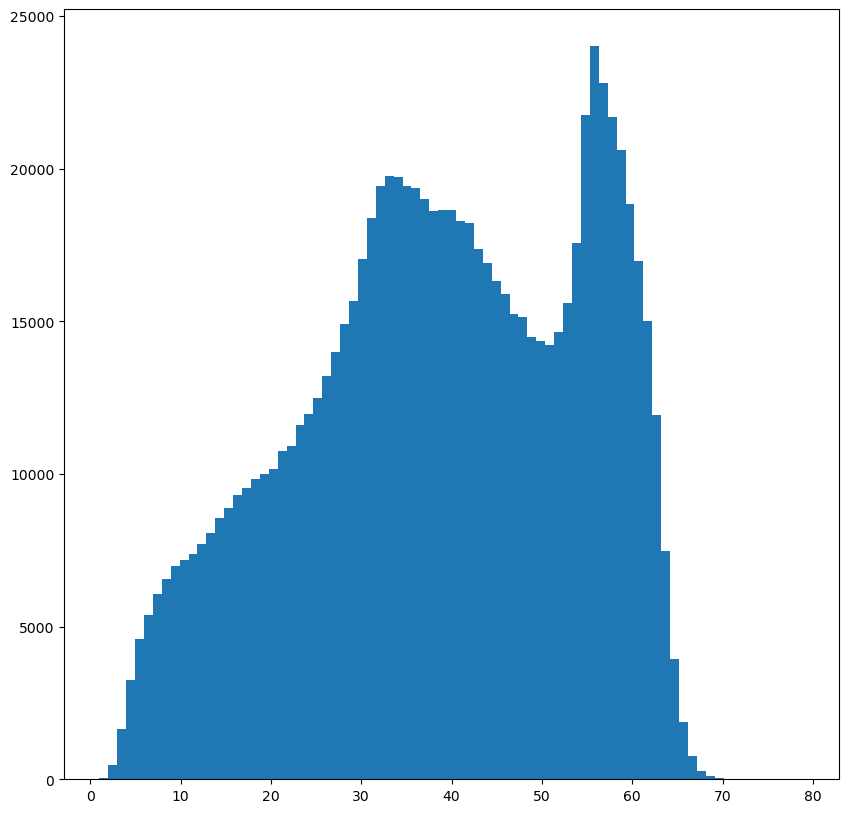

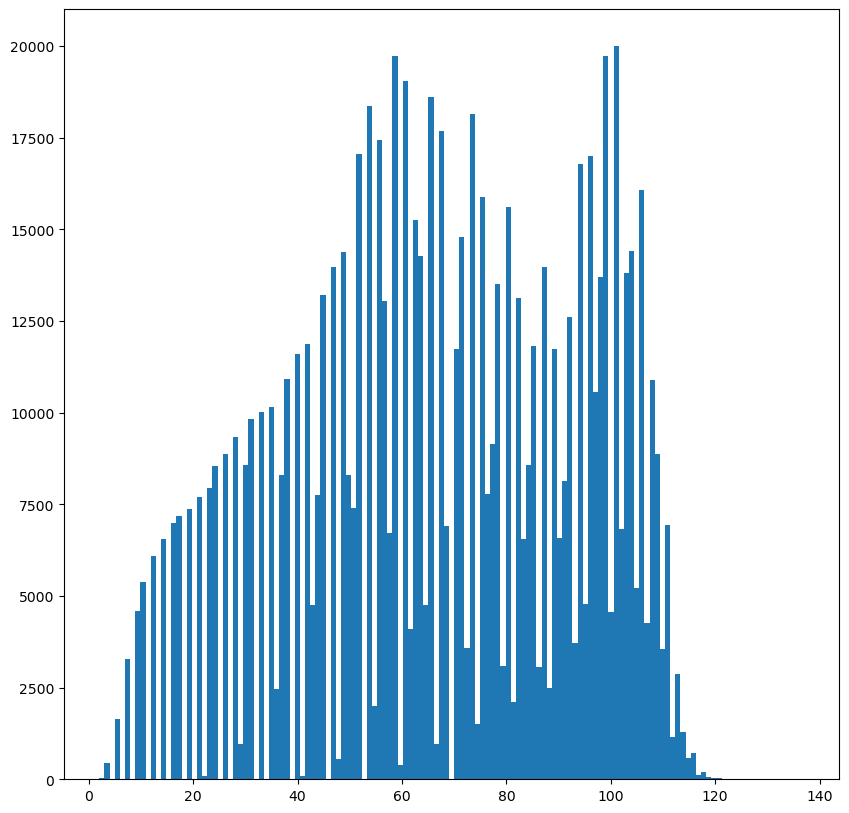

In [49]:
#map the intensity values to the new bins
#the bin_ration will be the minimum unit of intensity, so we need to divide the intensity by the bin_ratio.T
id = im_data.IDs[5] #take the first patient as example
pat = patient(id, im_data)

im_original = pat.im(format='np', preprocess=False)
im_process = pat.im(format='np', preprocess=True)
im_rescaled = scale_to_bin_ratio(im_process, bin_ratio)
print(f'The unique values of the original image are {np.unique(pat.im(format="np", preprocess=False)).shape[0]}')
print(f'The unique values of the rescaled image are {np.unique(im_rescaled).shape[0]}')

#show histogram of the original image without taking into account the background
plt.figure(figsize=(10,10))
plt.hist(np.extract(im_original>0, im_original), bins=max(im_original.ravel()))
plt.figure(figsize=(10,10))
plt.hist(np.extract(im_rescaled>0, im_rescaled), bins=max(im_rescaled.ravel()))

Now, we can compute the max and min with this new range.

In [53]:
rescaled_max, _ = get_maxmin_intensity(im_data, preprocess=True, rescaled=True, bin_ratio=bin_ratio)
print(f'The maximum intensity of the rescaled image is {rescaled_max}')

The maximum intensity is 215
The minimum intensity is 0
The maximum intensity of the rescaled image is 215


# Section 2: Accumulate the histograms across all patients

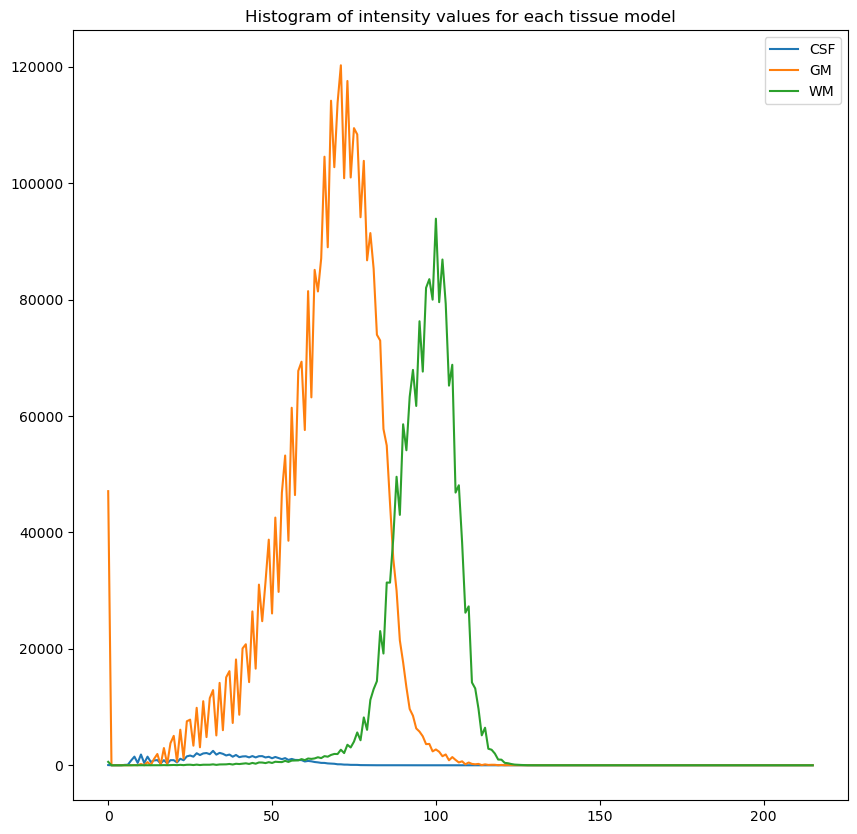

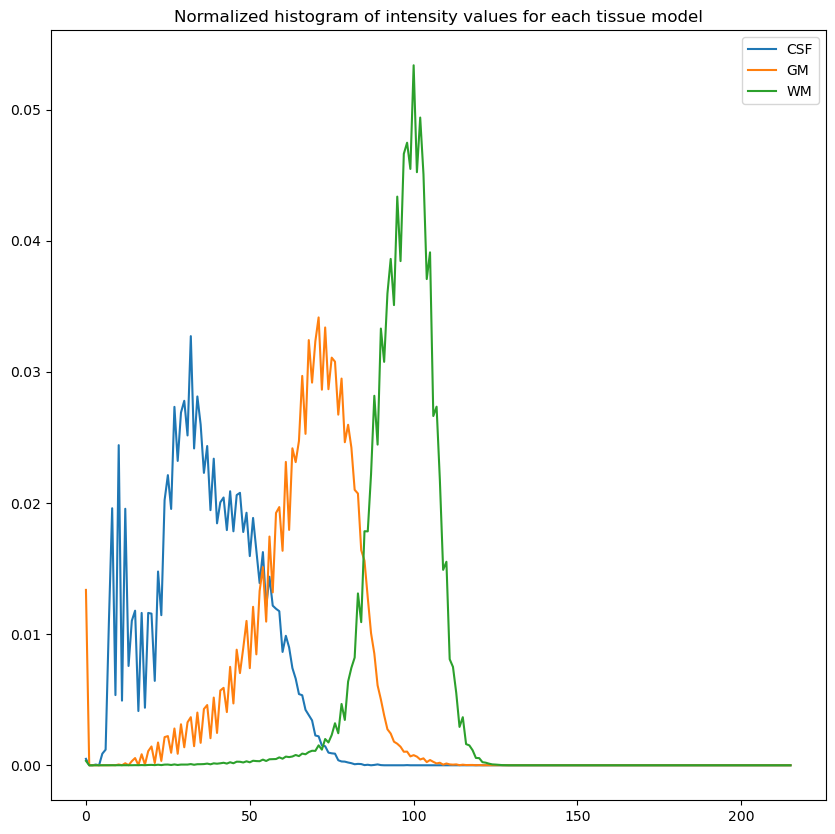

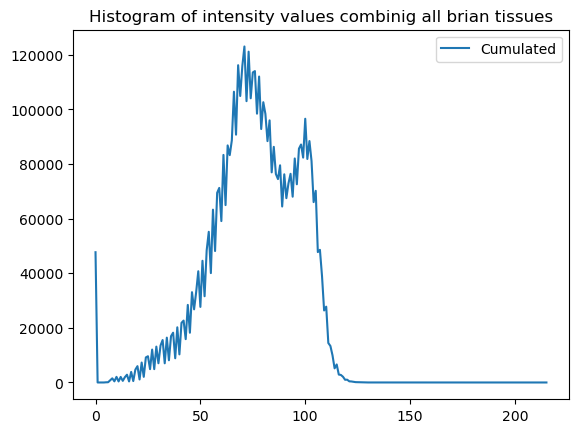

In [73]:
#Now we can extract a histogram for each tissue and each patient

#Define range of intensity values
max_int = rescaled_max + 1; min_int = 0
bins = np.arange(min_int, max_int + 1) #Define bins for histogram (Numpy bin_edges are open intervals on the right)

#Store count values in array
tot_csf = np.zeros(shape=(max_int,))
tot_wm = np.zeros(shape=(max_int,))
tot_gm = np.zeros(shape=(max_int,))

for id in im_data.IDs:
    #define patient
    pat = patient(id, im_data)
    im_process = pat.im(format='np', preprocess=True)
    im_rescaled = scale_to_bin_ratio(im_process, bin_ratio)
    csf_ext = np.extract(pat.labels(format='np').ravel() == 1, im_rescaled.ravel())
    gm_ext = np.extract(pat.labels(format='np').ravel() == 2, im_rescaled.ravel())
    wm_ext = np.extract(pat.labels(format='np').ravel() == 3, im_rescaled.ravel())

    val_csf, _ = np.histogram(csf_ext, bins=bins)
    val_gm, _ = np.histogram(gm_ext, bins=bins)
    val_wm, _ = np.histogram(wm_ext, bins=bins)
    
    tot_csf += val_csf
    tot_gm += val_gm
    tot_wm += val_wm


#Plot three histograms given values and bins
plt.figure(figsize=(10,10))
plt.plot(bins[:-1], tot_csf, label='CSF')
plt.plot(bins[:-1], tot_gm, label='GM')
plt.plot(bins[:-1], tot_wm, label='WM')
plt.legend()
plt.title('Histogram of intensity values for each tissue model')
plt.show()

#plot also the normalized histogram
norm_hist = normalize_histogram(tot_csf, tot_gm, tot_wm)

#Plot three histograms given values and bins
plt.figure(figsize=(10,10))
plt.plot(bins[:-1], norm_hist[0], label='CSF')
plt.plot(bins[:-1], norm_hist[1], label='GM')
plt.plot(bins[:-1], norm_hist[2], label='WM')
plt.legend()
plt.title('Normalized histogram of intensity values for each tissue model')
plt.show()

#Now we combine the counts of the three tissues to preper for normalisation.
three_hist = np.array([tot_csf,tot_gm,tot_wm]).T
three_sum = np.sum([tot_csf,tot_gm,tot_wm], axis=0)
plt.plot(bins[:-1], three_sum, label='Cumulated')
plt.legend()
plt.title('Histogram of intensity values combinig all brian tissues')
plt.show()



# Section 3: Tissue model

/tmp/ipykernel_223883/3257460344.py:2: RuntimeWarning: invalid value encountered in divide
  three_hist_norm = three_hist/three_sum[:,None]


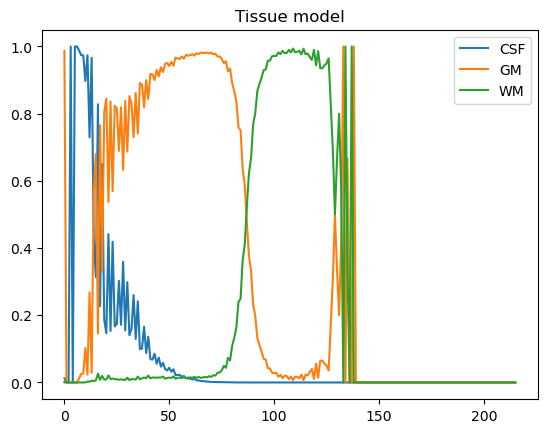

In [137]:
#Normilize histogram bin-wise
three_hist_norm = three_hist/three_sum[:,None]
#Make nan values 0
tissue_model = np.nan_to_num(three_hist_norm)
#plot tissue model
plt.plot(bins[:-1], tissue_model[:,0], label='CSF')
plt.plot(bins[:-1], tissue_model[:,1], label='GM')
plt.plot(bins[:-1], tissue_model[:,2], label='WM')
plt.legend()
plt.title('Tissue model')
plt.show()

#save tissue model
utils.save_as_pickle(tissue_model, str(repo_path / 'data'/'atlas_data'/'tissue_model.p'))

# Segment

Now that we have the tissue model, we can segment the images.

In [7]:
def my_argmax(array):
    """argnmax function but turns intensity cases where more than one tissue has a pick probability to -1"""
    rows = np.where(array == array.max(axis=1)[:, None])[0]
    rows_multiple_max = rows[:-1][rows[:-1] == rows[1:]]
    my_argmax = array.argmax(axis=1)
    my_argmax[rows_multiple_max] = -1
    return my_argmax

def maxProb_TModel(tissue_model):
    """get maximum probability tissue model using armax function

    Args:
        tissue_model (_type_): _description_

    Returns:
        _type_: _description_
    """
    max_label = my_argmax(tissue_model)
    return max_label

def get_bin_ratio():
    im_data = ImageDataset(set_name='Training')

    original_max, _ = get_maxmin_intensity(im_data, preprocess=False)
    prepross_max,_ = get_maxmin_intensity(im_data, preprocess=True)
    bin_ratio = prepross_max/original_max
    return bin_ratio

In [5]:
def Tmodel_segmentation(set_name, tissue_model, bin_ratio, save_csv=True, save_nifti=False):

    im_data = ImageDataset(set_name=set_name)
    #Define dataframe to store dice results
    df = pd.DataFrame(columns=['id'])
    df['id'] = im_data.IDs
    dice_all = np.zeros(shape=(im_data.len, 3)) #array to store dice results

    #we are working on segmenting the validation set images

    for i, id in enumerate(im_data.IDs): #Go through all patients
        pat = patient(id, im_data) #define patient
        #get image as array
        im = pat.im(format='np', preprocess=True)
        #scale preprocessed image using bin_ratio
        im = scale_to_bin_ratio(im, bin_ratio=bin_ratio)
        #Get tissue model
        LUT_TModel = maxProb_TModel(tissue_model) + 1 #shifted labels ot include background
        #enlarge tissue model to image intensities
        if im.max()>tissue_model.shape[0]:
            LUT_TModel = np.pad(LUT_TModel, (0, int(im.max())-tissue_model.shape[0]+1), 'constant', constant_values=0)
        #ensure that background is 0
        LUT_TModel[0] = 0
        #Use look up table on the original image intensities
        im_seg = LUT_TModel[im]
        
        #save segmentation if save_nifti is True
        if save_nifti:
            #save im_seg
            filename = str(repo_path / 'data'/ 'segmentations'/f'TModel_{id}_seg.nii.gz')
            utils.save_as_nifti(im_seg, filename, reference_path=pat.labels_path, dtype=np.uint8)
        
        #get dice score
        dice = np.zeros(shape=(3,))
        for tissue in range(1,4):
            dice_all[i, tissue-1] = utils.dice_score(pat.labels(format='np')==tissue, im_seg==tissue)

        #saving in dataframe
        df['CSF'] = dice_all[:,0] #assign dice results to dataframe
        df['GM'] = dice_all[:,1]
        df['WM'] = dice_all[:,2]
        #save dataframe as csv
        df.to_csv(str(repo_path / 'data'/ 'results'/f'TModel_dice_{set_name}.csv'), index=False) if save_csv else None

In [8]:
set_name = 'Validation'
bin_ratio = get_bin_ratio()
tissue_model = utils.open_pickle(str(repo_path / 'data'/'atlas_data'/'tissue_model.p'))
save_csv = True

Tmodel_segmentation(set_name, tissue_model, bin_ratio, save_csv, save_nifti=True)

The maximum intensity is 215
The minimum intensity is 0
The maximum intensity is 2.282848794416359
The minimum intensity is 0


In [27]:
#open nifti
id = 11
image_path = str(repo_path / 'data'/ 'segmentations'/f'TModel_{id}_seg.nii.gz')
sitk_im = sitk.ReadImage(image_path)
array_im = sitk.GetArrayFromImage(sitk_im)

#save as nifti
filename = str(repo_path / 'data'/ 'segmentations'/f'trial.nii.gz')
sitk_saving = sitk.GetImageFromArray(array_im.astype(np.uint8))
sitk.WriteImage(sitk_saving, filename)

In [28]:
im_data = ImageDataset(set_name='Validation')
id = im_data.IDs[0]
pat = patient(id, im_data)
#actual
pat.labels(format='np').dtype

dtype('int16')